In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import pickle


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from utilities import getFraudData, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap

In [3]:
# Name of data file
datafile = "./data/creditcard.csv"

# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional of (y=1) cases held out for testing
testSize = 0.5

# Integer number of non-fraud cases kept in the training set
nonFraudInTraining = 5000

# Number of folds for GridSearchCV
nfolds = 5

# Number of samples (fraudulent, not fraudulent)
nSamples = (492, 125000)

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

names = ["Not Fraud", "Fraud"]

# Maximum iterations for iterative classification trainers
maxIter = 3000

# # Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(31, 316, 4).round(), np.array([500, 1000, 2000, 3000])]).astype('int')
# learningCurveFolds = np.array([500, 1000, 2000, 3000]).astype('int')

# Fraction of data held out from the training dataset for cross validation during learning curve evaluation
lcTestSize = 0.2

In [4]:
# Used for plot names
est = "fraud_mlp"
scoreText = "F1-Score"

In [5]:
data = getFraudData(datafile, nSamples, randomSeed)
print(f"Got data of shape: {data.shape}")

# Use all features except time (omitting as I don't want to handle anything time-series related)
featColNames = [name for name in data.columns if ((name != "Class") and (name != "Time"))] 

print(f"Got feature columns {featColNames}")

Importing data with 492 fraudulent and 125000 not fraudulent cases
Got data of shape: (125492, 31)
Got feature columns ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [6]:
# Create X, y, XTest, yTest
# Because of the imbalance in data, use half of the fraud cases and only 5000 of the non-fraud cases for training.  Then Test on the rest

fraudXFull = data.loc[data.Class == 1, featColNames].values
fraudyFull = data.loc[data.Class == 1, 'Class'].values

fraudX, fraudXTest, fraudy, fraudyTest = train_test_split(fraudXFull, fraudyFull, 
                                                      test_size=testSize, random_state=randomSeed)

notFraudXFull = data.loc[data.Class == 0, featColNames].values
notFraudyFull = data.loc[data.Class == 0, 'Class'].values

# Using train_test_split "backwards" because I want 5000 examples in my training set and the rest in test
notFraudXTest, notFraudX, notFraudyTest, notFraudy = train_test_split(notFraudXFull, notFraudyFull, 
                                                      test_size=nonFraudInTraining, random_state=randomSeed)

print('')
print(f'fraudX.shape = {fraudX.shape}')
print(f'fraudy.shape = {fraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(fraudy == 1).sum() / float(len(fraudy))} (should be 1)')

print('')
print(f'notFraudX.shape = {notFraudX.shape}')
print(f'notFraudy.shape = {notFraudy.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(notFraudy == 1).sum() / float(len(notFraudy))} (should be 1)')

XUnscaled = np.concatenate([fraudX, notFraudX])
XTestUnscaled = np.concatenate([fraudXTest, notFraudXTest])

# Scale X, XTest for use in learning algorithm 
scaler = StandardScaler()
X = scaler.fit_transform(XUnscaled)
XTest = scaler.transform(XTestUnscaled)

y = np.concatenate([fraudy, notFraudy])
yTest = np.concatenate([fraudyTest, notFraudyTest])

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(y == 1).sum() / float(len(y))} (should be ~0.05)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be ~.001)')



fraudX.shape = (246, 29)
fraudy.shape = (246,)
Ratio of y=1 to y=0 for Training data: 1.0 (should be 1)

notFraudX.shape = (5000, 29)
notFraudy.shape = (5000,)
Ratio of y=1 to y=0 for Training data: 0.0 (should be 1)

X.shape = (5246, 29)
y.shape = (5246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.04689287075867327 (should be ~0.05)

XTest.shape = (120246, 29)
yTest.shape = (120246,)
Ratio of yTest=1 to yTest=0 for Test data: 0.0020458060975001246 (should be ~.001)


# Initial Parameter Grid Search

In [7]:
hidden_layer_sizes = ((2, ), (4, ), (6, ), (10, ), (2, 2), (10, 2))
alphas =  [0.0001, 0.00031, 0.001]
paramGrid = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'alpha': alphas,
}


nData = -1 # (all)
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(MLPClassifier(activation='logistic', max_iter=maxIter, random_state=randomSeed),
                  param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                  verbose=10, return_train_score=True, scoring='f1')

In [8]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

pltNameSuffix = '_initial'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 5245 data samples
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:  1.8min remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.9min finished


In [9]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.622038,0.695153,0.001795,7.463019e-04,0.0001,"(2,)","{'alpha': 0.0001, 'hidden_layer_sizes': (2,)}",0.937500,0.936170,0.936170,...,0.934516,0.016704,4,0.944297,0.939314,0.938992,0.934037,0.944297,0.940187,0.003842
1,4.695447,0.319488,0.001995,3.814697e-07,0.0001,"(4,)","{'alpha': 0.0001, 'hidden_layer_sizes': (4,)}",0.926316,0.946237,0.924731,...,0.933927,0.015551,7,0.941489,0.936508,0.938992,0.939314,0.941489,0.939559,0.001852
2,6.838317,0.230828,0.002194,3.999952e-04,0.0001,"(6,)","{'alpha': 0.0001, 'hidden_layer_sizes': (6,)}",0.926316,0.936170,0.924731,...,0.929989,0.016995,13,0.941489,0.936508,0.938992,0.939314,0.941489,0.939559,0.001852
3,8.375009,0.956862,0.003391,1.352670e-03,0.0001,"(10,)","{'alpha': 0.0001, 'hidden_layer_sizes': (10,)}",0.926316,0.936170,0.924731,...,0.931914,0.014439,10,0.941489,0.936508,0.938992,0.939314,0.941489,0.939559,0.001852
4,11.292808,0.242839,0.002394,4.883635e-04,0.0001,"(2, 2)","{'alpha': 0.0001, 'hidden_layer_sizes': (2, 2)}",0.926316,0.936170,0.937500,...,0.934822,0.013584,1,0.949868,0.944882,0.950131,0.947644,0.947368,0.947979,0.001912
5,16.900416,0.904472,0.002394,4.884611e-04,0.0001,"(10, 2)","{'alpha': 0.0001, 'hidden_layer_sizes': (10, 2)}",0.916667,0.936170,0.914894,...,0.917219,0.011512,17,0.955614,0.955844,0.952880,0.947917,0.947368,0.951924,0.003653
6,7.778204,0.333344,0.002194,3.993275e-04,0.00031,"(2,)","{'alpha': 0.00031, 'hidden_layer_sizes': (2,)}",0.937500,0.936170,0.936170,...,0.934516,0.016704,4,0.944297,0.939314,0.938992,0.934037,0.944297,0.940187,0.003842
7,5.629549,0.260183,0.001995,2.611745e-07,0.00031,"(4,)","{'alpha': 0.00031, 'hidden_layer_sizes': (4,)}",0.926316,0.946237,0.924731,...,0.933927,0.015551,7,0.941489,0.936508,0.938992,0.939314,0.941489,0.939559,0.001852
8,6.778876,0.314228,0.002394,4.886754e-04,0.00031,"(6,)","{'alpha': 0.00031, 'hidden_layer_sizes': (6,)}",0.926316,0.936170,0.924731,...,0.929989,0.016995,13,0.941489,0.936508,0.938992,0.939314,0.941489,0.939559,0.001852
9,8.326335,0.986057,0.003192,3.987551e-04,0.00031,"(10,)","{'alpha': 0.00031, 'hidden_layer_sizes': (10,)}",0.926316,0.936170,0.924731,...,0.931914,0.014439,10,0.941489,0.936508,0.938992,0.939314,0.941489,0.939559,0.001852


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2d810586dd8>)

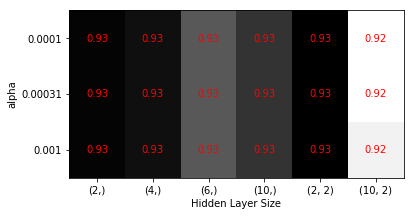

In [10]:
toPlot = np.zeros((len(alphas), len(hidden_layer_sizes)))
for i, hls in enumerate(alphas):
    for j, a in enumerate(hidden_layer_sizes):
        k = i * len(hidden_layer_sizes) + j
        toPlot[i, j] = gs_results_df.iloc[k].mean_test_score
heatmap(toPlot, hidden_layer_sizes, alphas, xlabel="Hidden Layer Size", ylabel="alpha", savefig=est + pltNameSuffix + "_gs")

In [11]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
yPred =  gs.best_estimator_.predict(X)
print(f'On the training data, we see precision and recall of:')
cr = classification_report(y, yPred, target_names=['Not Fraud', 'Fraud'])
print(cr)
print(f'but for the held-out test data we obtain just:')
yPred =  gs.best_estimator_.predict(XTest)
cr = classification_report(yTest, yPred, target_names=['Not Fraud', 'Fraud'])
print(cr)

From this, we choose the following parameters for computing the learning curve:
{'alpha': 0.0001, 'hidden_layer_sizes': (2, 2)}
On the training data, we see precision and recall of:
             precision    recall  f1-score   support

  Not Fraud       1.00      1.00      1.00      5000
      Fraud       0.98      0.91      0.95       246

avg / total       1.00      1.00      1.00      5246

but for the held-out test data we obtain just:
             precision    recall  f1-score   support

  Not Fraud       1.00      1.00      1.00    120000
      Fraud       0.44      0.80      0.57       246

avg / total       1.00      1.00      1.00    120246



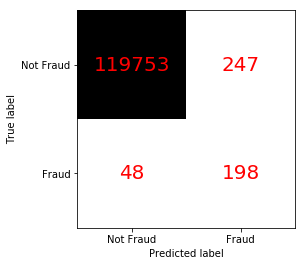

In [12]:
predictions = gs.predict(XTest)
ax = plotConfusionMatrix(yTest, predictions, names, savefig=est + pltNameSuffix + "_confusion")

# Learning Curves

Produce learning curves (train/test accuracy vs number of examples and train/score time vs number of examples) using the above chosen parameters to determine:

* Whether the classifier is bias or variance limited
* Limit to which more data points will not be helpful

In [13]:
lc_params = copy.deepcopy(gs.best_params_)

lcNameBase = est + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(MLPClassifier(activation='logistic', max_iter=maxIter, random_state=randomSeed, **lc_params), 
                          X, y, 
                          testSize = lcTestSize, scorer=f1_score, 
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                          randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'alpha': 0.0001, 'hidden_layer_sizes': (2, 2)}
Over 8 folds: [  31   67  146  316  500 1000 2000 3000]
Indices included at fold 0: 31
	Model trained in 0.60s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.61s
Indices included at fold 1: 67


C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


	Model trained in 0.58s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.58s
Indices included at fold 2: 146
	Model trained in 0.72s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 0.73s
Indices included at fold 3: 316
	Model trained in 0.99s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 1.00s
Indices included at fold 4: 500
	Model trained in 1.79s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 1.79s
Indices included at fold 5: 1000
	Model trained in 2.48s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 2.49s
Indices included at fold 6: 2000
	Model trained in 3.09s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.00s
	Total time for this iteration = 3.10s
Indi

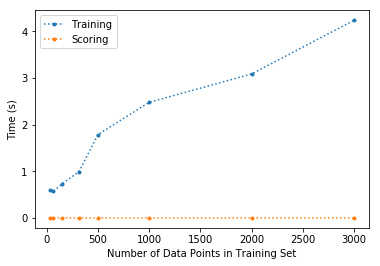

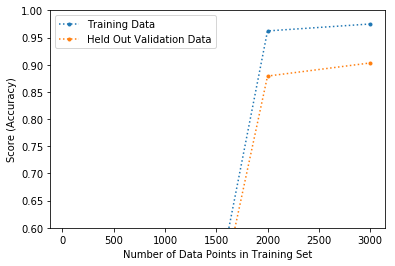

No handles with labels found to put in legend.


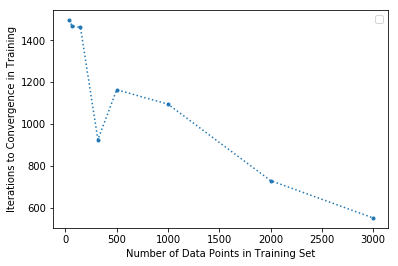

In [14]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, bottom=accuracyMin, top=accuracyMax, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

plotIterationCurve(lc, savefig = lcNameBase + "_iteration")

In [15]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.903 achieved with 3000 samples
